# Architecture Analysis



In [1]:
import pandas as pd

# Define the column names
column_names = ["heads", "layers", "hidden", "intermediate", "params"]

# Read the TSV file without header and assign column names
df = pd.read_csv("ablation_params.tsv", sep="\t", header=None, names=column_names)

print(df)

      heads  layers  hidden  intermediate    params
0        10      12     160           160   2162080
1        10      12     160           240   2622880
2        10      12     160           320   3083680
3        10      12     160            80   1701280
4        10      12     240           120   3819120
...     ...     ...     ...           ...       ...
1339      8      20     512           768  44610048
1340      8      20      64           128    824896
1341      8      20      64            32    456256
1342      8      20      64            64    579136
1343      8      20      64            96    702016

[1344 rows x 5 columns]


In [68]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

def plot_loss_by_param_range(directory, df_params, min_params, max_params, 
                             output_csv,
                             color_by="params",  # options: "params", "high_layers", "compress"
                             ):
    """
    Plots loss curves from Hugging Face Trainer JSONs in `directory` where params are in the given range.
    
    Args:
        directory (str): Path to directory containing trainer state JSON files.
        df_params (pd.DataFrame): DataFrame with columns: heads, layers, hidden, intermediate, params.
        min_params (int): Minimum number of parameters.
        max_params (int): Maximum number of parameters.
        output_csv (str): File path to save the filtered DataFrame.
    """
    files = [f for f in os.listdir(directory) if f.endswith(".json")]
    plot_data = []


    def high_layers(row):
        if row["heads"] in {6, 8, 10}:
            return row["layers"] >= row["heads"] + 8
        elif row["heads"] in {12, 14, 16}:
            return row["layers"] >= row["heads"] + 10
        return False

    def compress(row):
        return row["intermediate"] <= row["hidden"]




    for file in files:
        try:
            # Parse architectural info from filename
            parts = file.replace(".json", "").split("_")
            if len(parts) < 5:
                continue
            heads, layers, hidden, intermediate = map(int, parts[:4])

            # Match row in df_params
            match = df_params[
                (df_params["heads"] == heads) &
                (df_params["layers"] == layers) &
                (df_params["hidden"] == hidden) &
                (df_params["intermediate"] == intermediate)
            ]
            if match.empty:
                continue
            params = match["params"].iloc[0]
            if not (min_params <= params <= max_params):
                continue

            # Read JSON and collect loss info
            with open(os.path.join(directory, file)) as f:
                data = json.load(f)
                for entry in data.get("log_history", []):
                    if "loss" in entry:
                        plot_data.append({
                            "step": entry["step"],
                            "loss": entry["loss"],
                            "params": params,
                            "config": f"{heads}_{layers}_{hidden}_{intermediate}", 
                            "heads": heads,
                            "layers": layers,
                            "hidden": hidden,
                            "intermediate": intermediate
                        })
        except Exception as e:
            print(f"Failed to process {file}: {e}")

    # Plot
    if not plot_data:
        print("No data found in the specified range.")
        return
    
    df_plot = pd.DataFrame(plot_data)
    df_plot["high_layers"] = df_plot.apply(high_layers, axis=1)
    df_plot["compress"] = df_plot.apply(compress, axis=1)
    print(df_plot)
    df_plot.to_csv(output_csv, index=False)
    print(f"Saved filtered loss data to {output_csv}")

    norm = mcolors.Normalize(vmin=df_plot["params"].min(), vmax=df_plot["params"].max())
    cmap = cm.viridis

# Plot
    fig, ax = plt.subplots(figsize=(10, 6))

    if color_by == "params":
        norm = mcolors.Normalize(vmin=df_plot["params"].min(), vmax=df_plot["params"].max())
        cmap = cm.viridis
        for config, group in df_plot.groupby("config"):
            param_val = group["params"].iloc[0]
            color = cmap(norm(param_val))
            ax.plot(group["step"], group["loss"], color=color)
        sm = cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cbar = fig.colorbar(sm, ax=ax)
        cbar.set_label("Parameter Count")

    elif color_by in ["high_layers", "compress"]:
            color_map = {True: "tab:blue", False: "tab:orange"}
            label_shown = {True: False, False: False}

            for config, group in df_plot.groupby("config"):
                val = group[color_by].iloc[0]
                label = f"{color_by}={val}" if not label_shown[val] else None
                ax.plot(group["step"], group["loss"], color=color_map[val], label=label, alpha=0.8)
                label_shown[val] = True

            ax.legend(title=color_by)


    ax.set_xlabel("Step")
    ax.set_ylabel("Loss")
    ax.set_title(f"Training Loss Colored by {color_by}")
    ax.grid(True)

    plt.tight_layout()
    plt.show()

    return df_plot




         step    loss   params        config  heads  layers  hidden  \
0       20000  2.0382  4401600  8_14_192_288      8      14     192   
1       40000  1.8051  4401600  8_14_192_288      8      14     192   
2       60000  1.7387  4401600  8_14_192_288      8      14     192   
3       80000  1.6964  4401600  8_14_192_288      8      14     192   
4      100000  1.6664  4401600  8_14_192_288      8      14     192   
...       ...     ...      ...           ...    ...     ...     ...   
7790  1740000  1.4486  3627456  8_14_192_192      8      14     192   
7791  1760000  1.4490  3627456  8_14_192_192      8      14     192   
7792  1780000  1.4474  3627456  8_14_192_192      8      14     192   
7793  1800000  1.4487  3627456  8_14_192_192      8      14     192   
7794  1820000  1.4462  3627456  8_14_192_192      8      14     192   

      intermediate  high_layers  compress  
0              288        False     False  
1              288        False     False  
2              

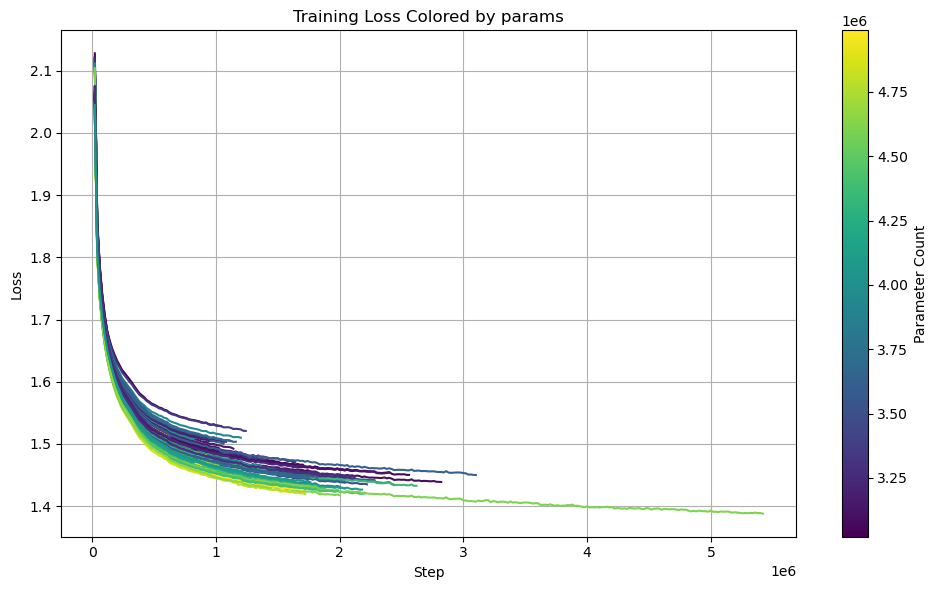

In [93]:
sorted_df = plot_loss_by_param_range(
    directory="trainer_states",
    df_params=df,
    min_params=3_000_000,
    max_params=5_000_000,
    #sort_step=3_000_000,
    output_csv="loss_3M_5M.csv", 
    color_by="params"
)

        step    loss   params        config  heads  layers  hidden  \
0      20000  2.0057  8314272  6_10_288_576      6      10     288   
1      40000  1.7825  8314272  6_10_288_576      6      10     288   
2      60000  1.7167  8314272  6_10_288_576      6      10     288   
3      80000  1.6727  8314272  6_10_288_576      6      10     288   
4     100000  1.6405  8314272  6_10_288_576      6      10     288   
...      ...     ...      ...           ...    ...     ...     ...   
4911  560000  1.4507  8933632  4_16_256_384      4      16     256   
4912  580000  1.4473  8933632  4_16_256_384      4      16     256   
4913  600000  1.4451  8933632  4_16_256_384      4      16     256   
4914  620000  1.4395  8933632  4_16_256_384      4      16     256   
4915  640000  1.4367  8933632  4_16_256_384      4      16     256   

      intermediate  high_layers  compress  
0              576        False     False  
1              576        False     False  
2              576        F

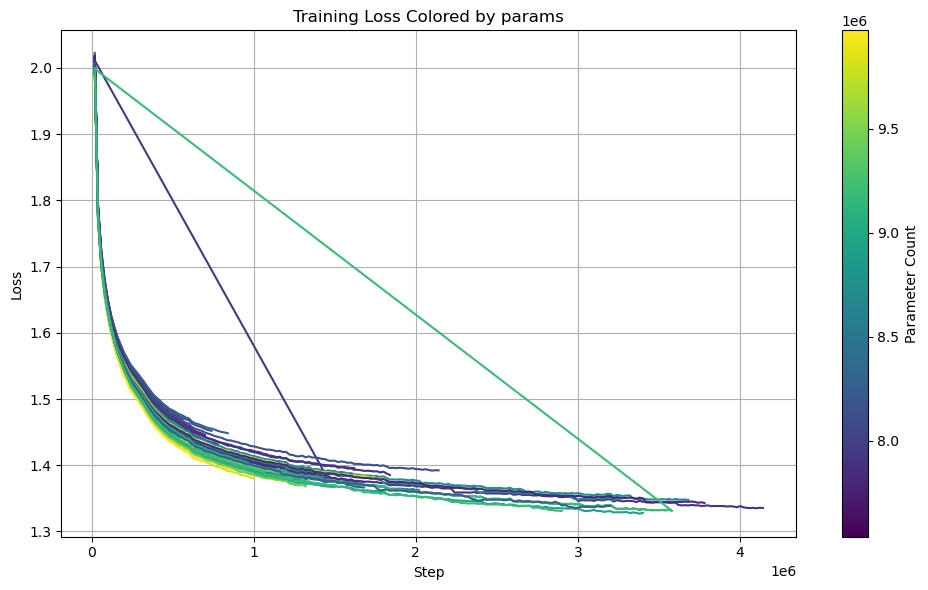

In [94]:
sorted_df = plot_loss_by_param_range(
    directory="trainer_states",
    df_params=df,
    min_params=7_500_000,
    max_params=10_000_000,
    #sort_step=3_000_000,
    output_csv="loss_7.5M_10M.csv", 
    color_by="params"
)


         step    loss    params         config  heads  layers  hidden  \
0       20000  1.9754  14630784  16_18_384_192     16      18     384   
1       40000  1.7496  14630784  16_18_384_192     16      18     384   
2       60000  1.6808  14630784  16_18_384_192     16      18     384   
3       80000  1.6389  14630784  16_18_384_192     16      18     384   
4      100000  1.6080  14630784  16_18_384_192     16      18     384   
...       ...     ...       ...            ...    ...     ...     ...   
3131   940000  1.3549  14509312  16_26_256_384     16      26     256   
3132   960000  1.3536  14509312  16_26_256_384     16      26     256   
3133   980000  1.3516  14509312  16_26_256_384     16      26     256   
3134  1000000  1.3503  14509312  16_26_256_384     16      26     256   
3135  1020000  1.3488  14509312  16_26_256_384     16      26     256   

      intermediate  high_layers  compress  
0              192        False      True  
1              192        False    

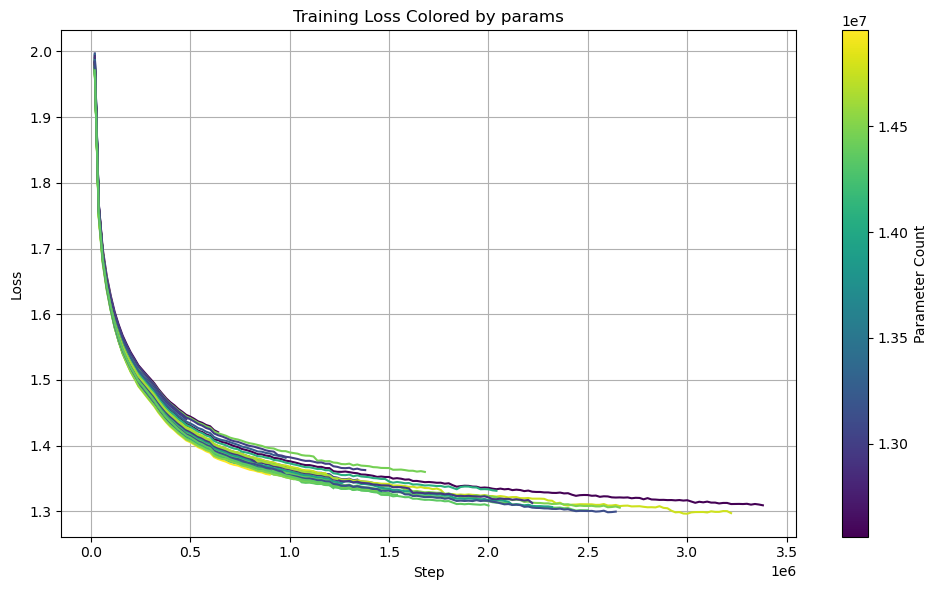

In [95]:
sorted_df = plot_loss_by_param_range(
    directory="trainer_states",
    df_params=df,
    min_params=12_500_000,
    max_params=15_000_000,
    #sort_step=3_000_000,
    output_csv="loss_12.5M_15M.csv", 
    color_by="params"
)


        step    loss    params         config  heads  layers  hidden  \
0      20000  1.9560  24983952  14_26_336_504     14      26     336   
1      40000  1.7330  24983952  14_26_336_504     14      26     336   
2      60000  1.6633  24983952  14_26_336_504     14      26     336   
3      80000  1.6197  24983952  14_26_336_504     14      26     336   
4     100000  1.5848  24983952  14_26_336_504     14      26     336   
...      ...     ...       ...            ...    ...     ...     ...   
1449  620000  1.3500  22609104  14_20_336_672     14      20     336   
1450  640000  1.3472  22609104  14_20_336_672     14      20     336   
1451  660000  1.3450  22609104  14_20_336_672     14      20     336   
1452  680000  1.3426  22609104  14_20_336_672     14      20     336   
1453  700000  1.3399  22609104  14_20_336_672     14      20     336   

      intermediate  high_layers  compress  
0              504         True     False  
1              504         True     False  
2  

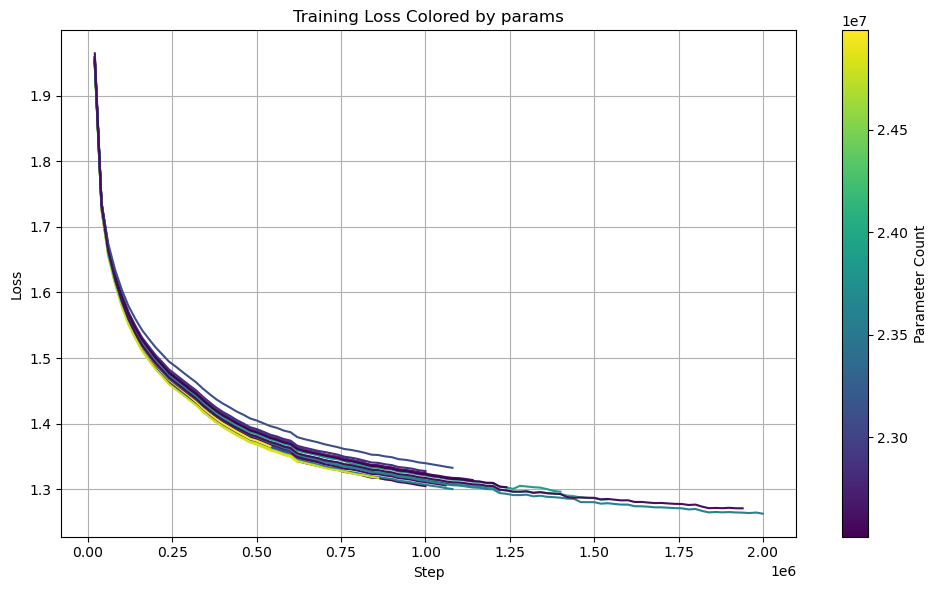

In [99]:
sorted_df = plot_loss_by_param_range(
    directory="trainer_states",
    df_params=df,
    min_params=22_500_000,
    max_params=25_000_000,
    #sort_step=3_000_000,
    output_csv="loss_22.5M_25M.csv", 
    color_by="params"
)


       step    loss    params          config  heads  layers  hidden  \
0     20000  1.9241  46492992  12_14_576_1152     12      14     576   
1     40000  1.7090  46492992  12_14_576_1152     12      14     576   
2     60000  1.6372  46492992  12_14_576_1152     12      14     576   
3     80000  1.5895  46492992  12_14_576_1152     12      14     576   
4    100000  1.5523  46492992  12_14_576_1152     12      14     576   
..      ...     ...       ...             ...    ...     ...     ...   
784  640000  1.3003  45168192   12_16_576_864     12      16     576   
785  660000  1.2976  45168192   12_16_576_864     12      16     576   
786  680000  1.2950  45168192   12_16_576_864     12      16     576   
787  700000  1.2916  45168192   12_16_576_864     12      16     576   
788  720000  1.2895  45168192   12_16_576_864     12      16     576   

     intermediate  high_layers  compress  
0            1152        False     False  
1            1152        False     False  
2     

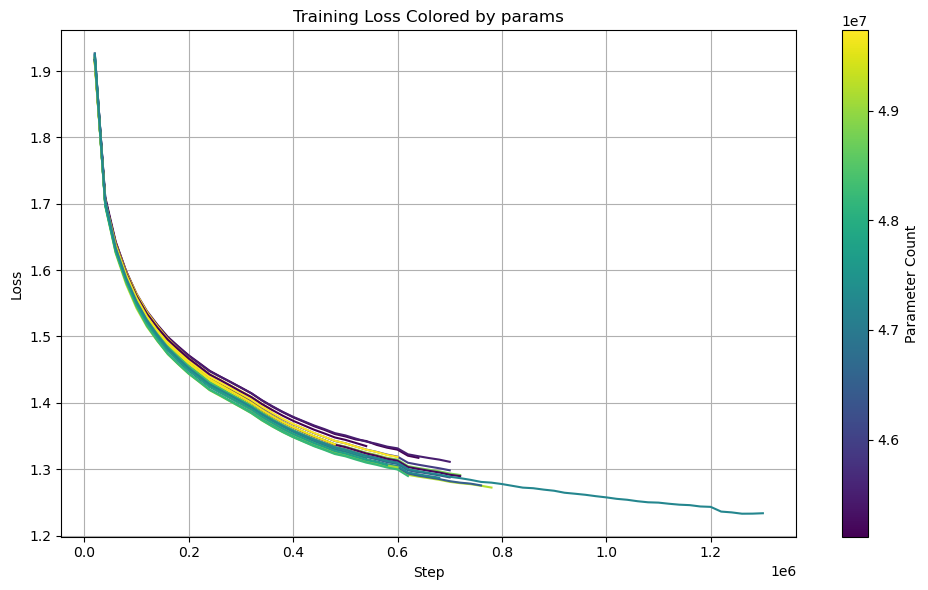

In [98]:
sorted_df = plot_loss_by_param_range(
    directory="trainer_states",
    df_params=df,
    min_params=45_000_000,
    max_params=50_000_000,
    #sort_step=3_000_000,
    output_csv="loss_45M_50M.csv", 
    color_by="params"
)
